# LIGO Project
## PyCBC GW Match

In [1]:
# Filter the LIGO .gwf data file using the pyCBC software package
# Based on Alex Nitz's sample code
# Some lines added by Hao Liu to parameterize the program and for outputs

directory = 'Data/' # directory where the data files are located
suffix_32 = '_LOSC_4_V2-1126259446-32' # suffix of the file name, not including ".gwf"
suffix_4096 = '_LOSC_4_V2-1126257414-4096'
match_low_frequency_cutoff = 43. # low frequency cutoff for matching, normally chosen to be same as highpass_freq
highpass_freq = 15 # frequency for the initial high pass (Hz)
window_edge = 4
snr_edge_cut = 1984 # length of edge-cut at both ends for max-SNR determination
psd_segment_length = 4 # segment length for calculating the PSD by Welch's averaging 4
f1 = match_low_frequency_cutoff
f2 = 300.

from pycbc.filter import qtransform as q
from pycbc_analysis import *


%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.close('all')

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
data = read_strain(directory,suffix_32,window_edge, print_info=True)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')
data = matched_filtering(data,print_info=True)

t = data['H']['TPL'].sample_times

 
****************************************************
H-file is: Data/H-H1_LOSC_4_V2-1126259446-32.gwf
H-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
L-file is: Data/L-L1_LOSC_4_V2-1126259446-32.gwf
L-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
H: Consider SNR only from 1126259446 to 1126259478, duration: 32.0
H-SNR: 18.615549354186882
H-time: 1126259446.541259766
H-phase: -2.8225527010438674
 
****************************************************
Bandpassing H-data from 43 Hz to 300 Hz.
 
****************************************************
L: Consider SNR only from 1126259446 to 1126259478, duration: 32.0
L-SNR: 13.33967589314095
L-time: 1126259446.534179688
L-phase: 0.5307061716488348
 
****************************************************
Bandpassing L-data from 43 Hz to 300 Hz.
Network SNR: 22.90165126562304


/home/jacob/.local/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## RW CC analysis

In [3]:
# Define functions

def rw_cor(time, signal, template, sr=4096, dt=0.21, step=0.01):
    """Calculates the running-window cross correlation between signal and
    template with window size dt and step size step."""
    
    # Initialize arrays and vals
    
    #time = np.round(time,30)
    t_i = time[0]-time[0]
    t_f = time[len(time)-1]-time[0]
    
    t1 = np.array([])
    t2 = np.array([])
    t = np.array([])
    i_sta = np.array([])
    i_sto = np.array([])
    cc = np.array([])
    
    t_1 = t_i
    t_2 = t_i + dt
    
    while t_i < t_f:
        
        # Slices signal and template into interval between t_1 and t_2
        # Convert slices to mpf.
        #indeces = np.where(np.logical_and(time>=t_1, time<=t_2))
        i_start = int(np.round(t_1*sr)) #int(indeces[0][0])
        i_stop = int(np.round(t_2*sr))+1 #int(indeces[0][-1])+1
        sgnl_int = signal[i_start:i_stop]
        tmpl_int = template[i_start:i_stop]
        
        # Calculate window position and cross correlation of signal and
        # template intervals.
        mid_time = (t_2+t_1)/2
        sgnl_int = sgnl_int-np.mean(sgnl_int)
        tmpl_int = tmpl_int-np.mean(tmpl_int)
        num = np.sum(sgnl_int*tmpl_int)
        den = np.sqrt(np.sum(sgnl_int**2)*np.sum(tmpl_int**2))
        if den == 0:
            cor = 0
        else:
            cor = num/den
            #cor = np.sum(sgnl_int*tmpl_int)/np.sqrt(np.sum(np.square(sgnl_int))\
                         #*np.sum(np.square(tmpl_int)))
        
        # Append values to defined arrays, repeat loop.
        t = np.append(t,mid_time)
        t1 = np.append(t1,t_1)
        t2 = np.append(t2,t_2)
        i_sta = np.append(i_sta, i_start)
        i_sto = np.append(i_sto, i_stop)
        cc = np.append(cc, cor)
        t_1 += step
        t_2 += step
        t_i = t_2
    
    return cc, t#, t1, t2, i_sta, i_sto

def running_avg(x, n):
    """ Running window average using 2n+1 data points to calculate average.
    """

    ravg = np.array([])
    
    # Add n/2 padding to each side of data. Use n/2 mirrored data-points
    # around i = o and i = len(x). n must be whole number
    stop = int(n/2)+1
    
    x = np.concatenate((np.flip(x[1:stop],-1),x))
    x = np.append(x,np.flip(x[-stop:len(x)-1],-1))
    
    # Calculate running average
    size = len(x)
    for i in range(size-n+1):
            avg = np.mean(x[i:n+i])
            ravg = np.append(ravg,avg)
    return ravg

def hist(data, no_bins = 0, pdf = True, title="",lbl="", color='k'):
    if no_bins == 0:
        no_bins = round(len(data)/3)
        print("No. of bins in '"+ title+"':")
        print(no_bins)
    values, bins = np.histogram(data, no_bins, density = pdf)
    center = (bins[:-1]+bins[1:])/2
    plt.plot(center,values,label=lbl,c=color)
    plt.title(title)
    if pdf == True:
        plt.ylabel("PDF")

def kullback_leibler(dist, model):
    vals = []
    dist = dist/np.sum(dist)
    model = model/np.sum(model)
    for i,j in zip(dist, model):
        if i == 0:
            val_tmp = 0
        else:
            val_tmp = i*np.log(i/j)
        vals.append(val_tmp)
    theta = np.sum(vals)
    return theta

In [4]:
# Running window CC analysis
# PyCBC

CCH_WBP, pos_WBP = rw_cor(t, data['H']['WBPTPL']._data, data['H']['WBPR']._data)
CCL_WBP, pos_WBP = rw_cor(t, data['L']['WBPTPL']._data, data['L']['WBPR']._data)
CCH_WBP = running_avg(CCH_WBP, 51)
CCL_WBP = running_avg(CCL_WBP, 51)

<IPython.core.display.Javascript object>


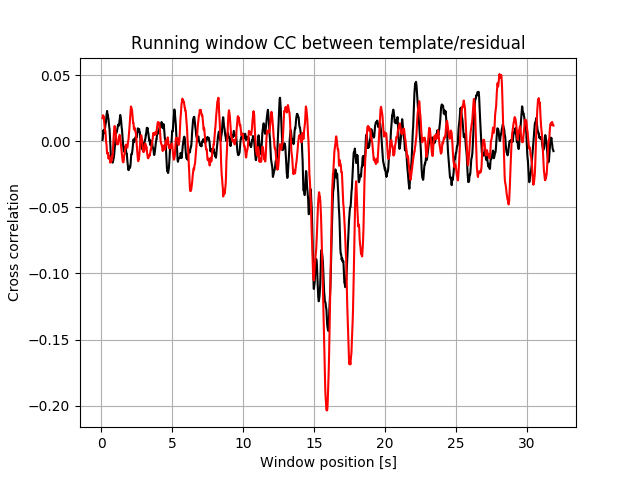

/home/jacob/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Running window CC between template/residual')

In [5]:
# Plot running window CC analysis
plt.close('all')
plt.figure(1)
plt.plot(pos_WBP, CCH_WBP, c='k', label='Hanford')
plt.plot(pos_WBP, CCL_WBP, c='r', label='Livingston')
#plt.axvline(16.36)
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
plt.grid('True')
plt.title('Running window CC between template/residual')

# Frequency analysis

In [35]:
data = read_strain(directory,suffix,window_edge, print_info=True)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')

plot = False
f1 = 43.
f2 = 300.
df = 40
f_step = 10.
n = int(np.ceil((f2-f1-df)/f_step))+1

min_bf = np.zeros(n)
min_af = np.zeros(n)

min_bf_normed = np.zeros(n)
min_af_normed = np.zeros(n)

freqs = np.zeros((2,n))

for i in range(n):
    
    bpf1 = f1+i*f_step
    bpf2 = f1+df+i*f_step
    
    freqs[:,i] = [bpf1,bpf2]

    data_tmp = matched_filtering(data, bpf1=bpf1, bpf2=bpf2)
    
    CCH, pos = rw_cor(t, data_tmp['H']['TPL']._data, data_tmp['H']['R']._data)
    CCL, pos = rw_cor(t, data_tmp['L']['TPL']._data, data_tmp['L']['R']._data)
    CCH = running_avg(CCH, 51)
    CCL = running_avg(CCL, 51)
        
    index1 = np.logical_and(pos > 14.00, pos<16.36)
    index2 = np.logical_and(pos > 16.36, pos<18.00)
    
    CCH_bf = CCH[index1].min()#/np.max(np.abs(CCH))
    CCL_bf = CCL[index1].min()#/np.max(np.abs(CCL))
    CCH_af = CCH[index2].min()#/np.max(np.abs(CCH))
    CCL_af = CCL[index2].min()#/np.max(np.abs(CCL))
    
    CCH_bf_normed = CCH_bf/np.max(np.abs(CCH))
    CCL_bf_normed = CCL_bf/np.max(np.abs(CCL))
    CCH_af_normed = CCH_af/np.max(np.abs(CCH))
    CCL_af_normed = CCL_af/np.max(np.abs(CCL))
    
    min_bf[i] = CCH_bf*CCL_bf/(CCH_bf+CCL_bf)
    min_af[i] = CCH_af*CCL_af/(CCH_af+CCL_af)
    min_bf_normed[i] = CCH_bf_normed*CCL_bf_normed/(CCH_bf_normed+CCL_bf_normed)
    min_af_normed[i] = CCH_af_normed*CCL_af_normed/(CCH_af+CCL_af_normed)
    
    if plot:
        plt.close('all')
        fig, ax = plt.subplots()
        ax.plot(pos, CCH, label='Hanford', c='k')
        ax.plot(pos, CCL, label='Livingston', c='r')
        ax.grid('True')
        ax.set_xlabel('Window Position [S]')
        ax.set_ylabel('Cross Correlation')

        min_bf_normed = np.round(min_bf_normed,2)
        min_af_normed = np.round(min_af_normed,2)
        
        string = 'Relative CC before event: %s \nRelative CC after event: %s' %(min_bf_normed[i], min_af_normed[i])
        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(color='none', label=string))
        lgd = ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_title('RW CC in Freq. band %s Hz to %s Hz' %(bpf1,bpf2))
        plt.savefig('Plots/Spectral analysis/%s_%s.pdf' %(bpf1,bpf2),bbox_extra_artists=(lgd,), bbox_inches='tight')

 
****************************************************
H-file is: Data/H-H1_LOSC_4_V2-1126259446-32.gwf
H-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
L-file is: Data/L-L1_LOSC_4_V2-1126259446-32.gwf
L-file is from 1126259446 to 1126259478, duration: 32


Conclusion: Dip before/after the event originate in the frequency band 43 Hz to 123 Hz. Above this, there are equally large fluctuations before, under and after the event. At higher frequencies we recover the dip before the event, but conclude that this must be caused by spectral leakage at high frequencies due to the fact that the template before the event only has low frequency content, as illustrated by the spectrograms in the next section. Need to look closer at the impact of spectral leakage for the dip before the event, and especially for the dip after the event, seeing as the template should quickly drop to zero.

## Spectral leakage analysis

Check fourier domain of template before and after bandpassing and whitening to look closer at spectral leakage. Focus on frequency band 40 - 100 Hz. Determine effect on cross correlation. Does spectral leakage dominate? Afterwards compare spectral leakage contribution between before event dip, and after event dip.

In [47]:
from pycbc.types.timeseries import TimeSeries

plt.close('all')

data = read_strain(directory,suffix_32,window_edge, print_info=False)
data = estimate_psd(data,psd_segment_length, psd_window='kaiser')
data = matched_filtering(data)

HS_freq = data['H']['S'].to_frequencyseries()
HWS_freq = data['H']['WS'].to_frequencyseries()
HWBPS_freq = data['H']['WBPS'].to_frequencyseries()
freqs = HS_freq.sample_frequencies

Constant Q-transform of raw data, whitened data, and whitened and bandpassed data, shown as spectrograms. Visualize change in frequency content after cleaning signal.

<IPython.core.display.Javascript object>


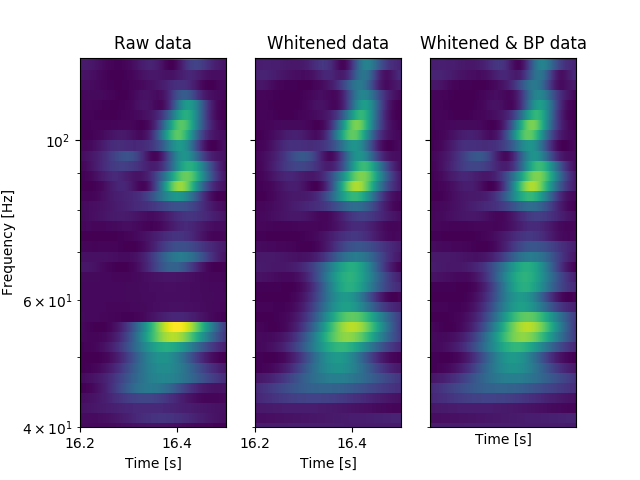

Text(0.5,1,'Whitened & BP data')

In [9]:
qplane_tiles_raw = q.qtiling(HS_freq,(32,32),(10,1E3))
_, times_raw, freqs_raw, power_raw = q.qplane(qplane_tiles_raw,HS_freq)
qplane_tiles_w = q.qtiling(HWS_freq,(32,32),(10,1E3))
_, times_w, freqs_w, power_w = q.qplane(qplane_tiles_w,HWS_freq)
qplane_tiles_wbp = q.qtiling(HWBPS_freq,(32,32),(10,1E3))
_, times_wbp, freqs_wbp, power_wbp = q.qplane(qplane_tiles_wbp,HWS_freq)

times_raw = times_raw-times_raw[0]
times_w = times_w-times_w[0]
times_wbp = times_wbp-times_wbp[0]

fig, (ax1, ax2, ax3)= plt.subplots(1, 3, sharex=False, sharey=True)
ax1.pcolormesh(times_raw, freqs_raw, power_raw)
ax2.pcolormesh(times_w, freqs_w, power_w)
ax3.pcolormesh(times_wbp, freqs_wbp, power_wbp)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_xlim(16.2,16.5)
ax2.set_xlim(16.2,16.5)
ax3.set_xlim(16.2,16.5)
ax1.set_ylim(40,130)
ax1.set_xlabel('Time [s]')
ax2.set_xlabel('Time [s]')
ax3.set_xlabel('Time [s]')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_title('Raw data')
ax2.set_title('Whitened data')
ax3.set_title('Whitened & BP data')

<IPython.core.display.Javascript object>


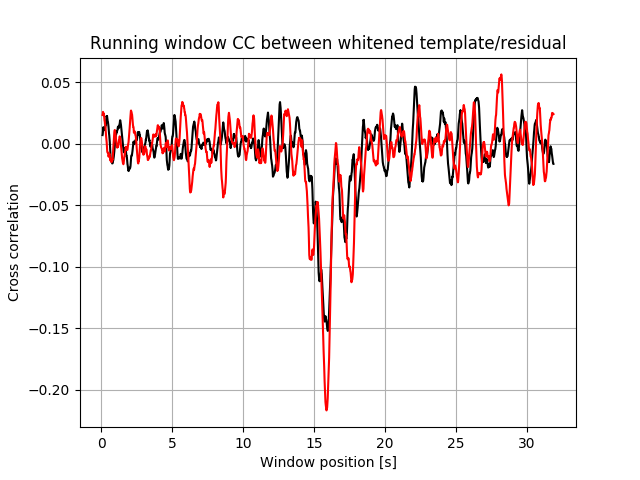

<IPython.core.display.Javascript object>


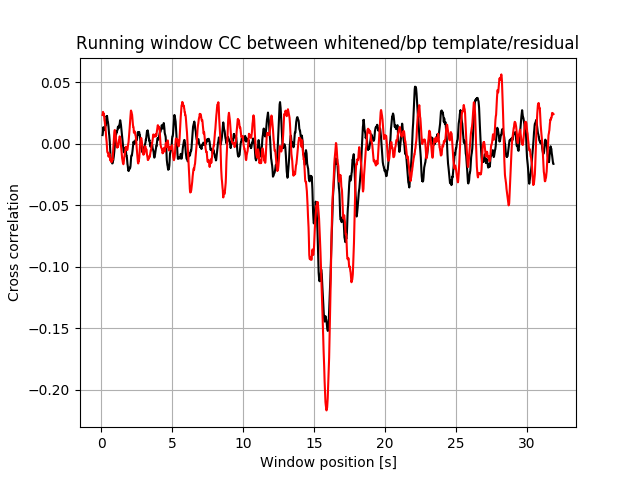

Text(0.5,1,'Running window CC between whitened/bp template/residual')

In [48]:
CCH_w, pos_w = rw_cor(t, data['H']['WTPL']._data, data['H']['WR']._data)
CCL_w, pos_w = rw_cor(t, data['L']['WTPL']._data, data['L']['WR']._data)
CCH_wbp, pos_wbp = rw_cor(t, data['H']['WBPTPL']._data, data['H']['WBPR']._data)
CCL_wbp, pos_wbp = rw_cor(t, data['L']['WBPTPL']._data, data['L']['WBPR']._data)
CCH_w = running_avg(CCH_w, 51)
CCL_w = running_avg(CCL_w, 51)
CCH_wbp = running_avg(CCH_wbp, 51)
CCL_wbp = running_avg(CCL_wbp, 51)

plt.figure(5)
plt.plot(pos_w, CCH_w, c='k', label='Hanford')
plt.plot(pos_w, CCL_w, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
plt.grid('True')
plt.title('Running window CC between whitened template/residual')

plt.figure(6)
plt.plot(pos_wbp, CCH_wbp, c='k', label='Hanford')
plt.plot(pos_wbp, CCL_wbp, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
plt.grid('True')
plt.title('Running window CC between whitened/bp template/residual')

Testing effects of using different windows when estimating the PSD, comparing with no window (rectangular window).

<IPython.core.display.Javascript object>


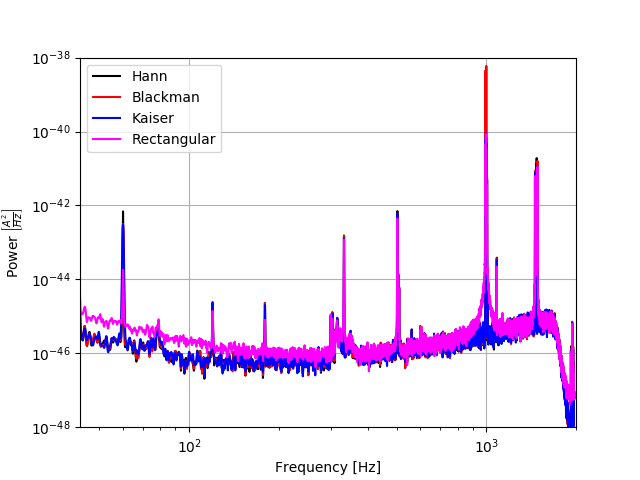

<IPython.core.display.Javascript object>


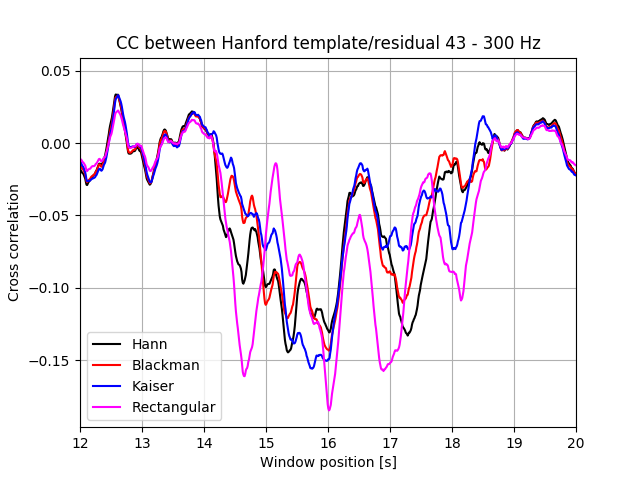

Text(0.5,1,'CC between Hanford template/residual 43 - 300 Hz')

In [14]:
bpf = 300

data = read_strain(directory,suffix_32,window_edge, print_info=False)

data_hann = estimate_psd(data,psd_segment_length, psd_window='hann')
data_hann = matched_filtering(data_hann, bpf2=bpf)


data_blackman = estimate_psd(data,psd_segment_length, psd_window='blackman')
data_blackman = matched_filtering(data_blackman, bpf2=bpf)


data_kaiser = estimate_psd(data,psd_segment_length, psd_window='kaiser', kaiser_beta=16)
data_kaiser = matched_filtering(data_kaiser, bpf2=bpf)

data_rectangular = estimate_psd(data,psd_segment_length, psd_window='rectangular')
data_rectangular = matched_filtering(data_rectangular, bpf2=bpf)

plt.figure(7)
plt.loglog(data_hann['H']['PSD'].sample_frequencies, data_hann['H']['PSD'],c='k',label='Hann')
plt.loglog(data_blackman['H']['PSD'].sample_frequencies, data_blackman['H']['PSD'],c='r', label='Blackman')
plt.loglog(data_kaiser['H']['PSD'].sample_frequencies, data_kaiser['H']['PSD'],c='b', label='Kaiser')
plt.loglog(data_rectangular['H']['PSD'].sample_frequencies, data_rectangular['H']['PSD'],c='magenta', label='Rectangular')
plt.xlim(43,2E3)
plt.ylim(1E-48,1E-38)
plt.grid('True')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Power $\left[\frac{A^2}{Hz}\right]$')
plt.legend()
#plt.savefig('Plots/Spectral leakage analysis/PSD_window_test.pdf')

t=data_hann['H']['WTPL'].sample_times

CCH_hann, pos_w = rw_cor(t, data_hann['H']['WBPTPL']._data, data_hann['H']['WBPR']._data)
CCH_blackman, pos_w = rw_cor(t, data_blackman['H']['WBPTPL']._data, data_blackman['H']['WBPR']._data)
CCH_kaiser, pos_w = rw_cor(t, data_kaiser['H']['WBPTPL']._data, data_kaiser['H']['WBPR']._data)
CCH_rectangular, pos_w = rw_cor(t, data_rectangular['H']['WBPTPL']._data, data_rectangular['H']['WBPR']._data)
CCH_hann = running_avg(CCH_hann, 51)
CCH_blackman = running_avg(CCH_blackman, 51)
CCH_kaiser = running_avg(CCH_kaiser, 51)
CCH_rectangular = running_avg(CCH_rectangular, 51)

plt.figure(9)
plt.plot(pos_w, CCH_hann, label='Hann', c='k')
plt.plot(pos_w, CCH_blackman, label='Blackman', c='r')
plt.plot(pos_w, CCH_kaiser, label='Kaiser', c='b')
plt.plot(pos_w, CCH_rectangular, label='Rectangular', c='magenta')
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
plt.grid('True')
plt.legend()
plt.xlim(12,20)
plt.title('CC between Hanford template/residual 43 - 300 Hz')
#plt.savefig('Plots/Spectral leakage analysis/cc_window_test.pdf')

Testing effect of data length on PSD precision.

In [6]:
data_32 = read_strain(directory,suffix_32, window_edge, print_info=False)
data_126 = read_strain(directory,suffix_4096,window_edge, crop=snr_edge_cut, print_info=False)

data_32 = estimate_psd(data_32,psd_segment_length, psd_window='blackman')
data_126 = estimate_psd(data_126,psd_segment_length, psd_window='blackman')
data_32 = matched_filtering(data_32, bpf2=bpf)
data_126 = matched_filtering(data_126, bpf2=bpf)

ValueError: different delta_f

<IPython.core.display.Javascript object>


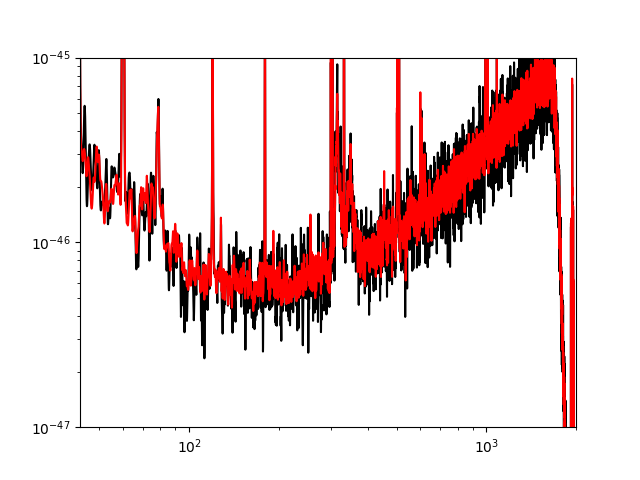

(1e-47, 1e-45)

In [25]:
freqs_32 = data_32['H']['PSD'].sample_frequencies
freqs_126 = data_126['H']['PSD'].sample_frequencies
plt.figure(10)
plt.loglog(freqs_32, data_32['H']['PSD'], c='k')
plt.loglog(freqs_126, data_126['H']['PSD'], c='r')
plt.xlim(43,2E3)
plt.ylim(1E-47,1E-45)